#### Data Mining I - Fall 2017

##  Data Mining Final Project - Jurgen Xhafaj

<br> Here, consider a movie set, called TMDB Movie set (initial nr of movies~4800). 
<br> The data given to us will be pre-release, and we want to predict the success of a movie based on actor, production company, and genre of the movie.
<br> On this Jupyter Notebook, you will see the process we followed to get to the given results.
<br> We will be using two different input files, one has the movies and stats, other has credits.

<br> First, we import the movie dataset, as well as some tools that we will need on the way. This includes the given setup file from Dr. Scott Cook.

In [11]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
from setup import *

In [12]:
csv_path="movies.csv"
df=pd.read_csv(csv_path, encoding='utf8')

### For the first part of this project, we will be using these columns:

In [13]:
df[['title','budget','revenue']].head()

,title,budget,revenue
0,Avatar,237000000,2787965087
1,Pirates of the Caribbean: At World's End,300000000,961000000
2,Spectre,245000000,880674609
3,The Dark Knight Rises,250000000,1084939099
4,John Carter,260000000,284139100


### Let us build a new column that show the ratio revenue/budget for original dataframe:

In [14]:
df['new_col']=df['revenue']/df['budget']
df['new_col'].head(5)

0   11.764
1    3.203
2    3.595
3    4.340
4    1.093
Name: new_col, Length: 5, dtype: float64

### The maximal value is below:

In [15]:
df['new_col'].max()

inf

#### Of course it's infinity, since there are entries with rev>0 and budget=0...
#### Below are the first 3 rows with budget=0 :

In [16]:
dfempty=df[df['budget']<1]
dfempty[['budget','title']].head(3)

,budget,title
265,0,The Cat in the Hat
321,0,The Campaign
359,0,Alvin and the Chipmunks: The Road Chip


#### Next, I would like to build a histogram with these entries of new_col, but I get an error. 
#### That is because those inf terms should be removed (division by zero).

### Let us look at a movie whose revenue is zero, then we check it online.
##### Scroll right a little bit to see the "Revenue" Column.

In [17]:
df[['title','revenue']][82:85]

,title,revenue
82,Dawn of the Planet of the Apes,710644566
83,The Lovers,0
84,47 Ronin,150962475


<br> After checking online, the budget for The Lovers is 2.10million dollars, which suggests these zeroes are missing data. At this point, we do not wish to add average revenue to zeroes because that would manipulate our data very heavily. Especially, considering that there are around 1000 movies with revenue=0 (unknown), the impact would be high.Therefore, we clean the data with revenue less than 1000.

#### Below, we do the first part of cleaning the data, by taking out the entries with revenue below 1000.
<br> This action was motivated from the fact that there is a big disparity between those values and the rest.

In [18]:
dfclean1=df[df['revenue']>1000]
dfclean1[['title','revenue']][82:84]

,title,revenue
82,Dawn of the Planet of the Apes,710644566
84,47 Ronin,150962475


<br> On the initial file, there is "The Lovers" in between these two (line 85 on Excel) but here it's been cleaned.
### Below, we do the second part of cleaning the data, by taking out the entries with budget below 1000.
<br> This action was motivated from the fact that there is a big disparity between those values and the rest.
<br> This is what it would look like on the original data frame that we imported. Notice how budget is shown as zero for "The Cat in the Hat".

In [19]:
df[['title','budget']][264:267]

,title,budget
264,Ali,107000000
265,The Cat in the Hat,0
266,"I, Robot",120000000


In [20]:
dfclean2=dfclean1[dfclean1['budget']>1000]
dfclean2[['title','budget']][262:264]

,title,budget
264,Ali,107000000
266,"I, Robot",120000000


<br> This works because "The Cat in the Hat" has been excluded from the list and the budget for it is zero, whereas in reality, the budget was actually 109 million dollars.
#### Next, we create a new column (coef) on our clean data, which will represent the ratio revenue/budget.

In [21]:
dfclean2['coef']=dfclean2['revenue']/df['budget']
dfclean2['coef'].head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0   11.764
1    3.203
2    3.595
3    4.340
4    1.093
Name: coef, Length: 5, dtype: float64

#### The lowest values seem to be fairly close to one another, so we do not need to remove outliers.

In [22]:
sorted(dfclean2['new_col'], reverse=False)[:10]

[0.00025596000000000001,
 0.00087394999999999997,
 0.00090689999999999998,
 0.0011339384615384614,
 0.0013586666666666667,
 0.0015333333333333334,
 0.0015857142857142858,
 0.0017472,
 0.0033210714285714284,
 0.0036116]

#### The top values have two very obvious outliers, which we will have to remove.

In [23]:
sorted(dfclean2['new_col'], reverse=True)[:10]

[12890.386666666667,
 4133.333333333333,
 700.0,
 500.0,
 439.61658461538462,
 426.64409999999998,
 420.52272307692306,
 363.04705882352943,
 311.70996503496502,
 270.0]

<sr> Below, we clean the first two values because they are outliers. We call the new dataframe dfclean3.

In [24]:
dfclean3=dfclean2[dfclean2['new_col']<4000]

#### Using dfclean2 from previous steps, it is interesting to find out which movie has the maximal coefficient, which would skew our data a lot for later use, so we took it away from the dataframe.

In [25]:
maximum = np.argmax(dfclean2['new_col'])
dfclean2.loc[maximum]

budget                                                              15000
genres                  [{"id": 27, "name": "Horror"}, {"id": 9648, "n...
homepage                         http://www.paranormalactivity-movie.com/
id                                                                  23827
keywords                [{"id": 10224, "name": "haunting"}, {"id": 147...
original_language                                                      en
original_title                                        Paranormal Activity
overview                After a young, middle class couple moves into ...
popularity                                                         47.457
production_companies    [{"name": "Blumhouse Productions", "id": 3172}...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                    9/14/2007
revenue                                                         193355800
runtime                               

#### Apparently the best performing one is Paranormal Activity.
<br> Let us have a look at the minimum value, which represents the movie that had the least financial success :(

In [26]:
minimum = np.argmin(dfclean2['new_col'])
dfclean2.loc[minimum]

budget                                                           25000000
genres                  [{"id": 14, "name": "Fantasy"}, {"id": 12, "na...
homepage                                                              NaN
id                                                                 227707
keywords                [{"id": 212, "name": "london england"}, {"id":...
original_language                                                      en
original_title                 The Adventurer: The Curse of the Midas Box
overview                17-year-old Mariah Mundi's life is turned upsi...
popularity                                                          8.843
production_companies    [{"name": "Matador Pictures", "id": 707}, {"na...
production_countries    [{"iso_3166_1": "BE", "name": "Belgium"}, {"is...
release_date                                                    12/5/2013
revenue                                                              6399
runtime                               

#### The movie with lowest financial coefficient was "The Adventurer: The Curse of the Midas Box".
<br> Let us normalize the coefficients from dfclean3 ,by using a function from preprocessing.

In [27]:
a=dfclean3['new_col']
preprocessing.normalize(a, norm='max' , axis=1, copy=False, return_norm=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(array([[ 0.01680509,  0.00457619,  0.00513513, ...,  0.00707143,
          0.08668571,  0.01325273]]), array([ 700.]))

#### The new top (normalized) coefficients are:

In [28]:
sorted(a, reverse=True)[:10]

[1.0,
 0.7142857142857143,
 0.62802369230769228,
 0.60949157142857135,
 0.60074674725274724,
 0.51863865546218491,
 0.44529995004995004,
 0.38571428571428573,
 0.37593984962406013,
 0.35714285714285715]

#### Now that we normalized coef of budget, we need to normalize popularity. Let us have a look at some values of popularity:

In [29]:
df['popularity'].head(10)

0   150.438
1   139.083
2   107.377
3   112.313
4    43.927
5   115.700
6    48.682
7   134.279
8    98.886
9   155.790
Name: popularity, Length: 10, dtype: float64

#### Least values for popularity are:

In [30]:
sorted(dfclean3['popularity'], reverse=False)[:5]

[0.019984000000000002,
 0.031947000000000003,
 0.034258999999999998,
 0.037073000000000002,
 0.039007]

#### Top values for popularity are:

In [31]:
sorted(dfclean3['popularity'], reverse=True)[:5]

[875.58130500000004,
 724.24778400000002,
 514.56995599999993,
 481.09862400000003,
 434.27856399999996]

#### Normalize popularity values:

In [32]:
b=dfclean3['popularity']

preprocessing.normalize(b, norm='max' , axis=1, copy=False, return_norm=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(array([[ 0.17181451,  0.15884603,  0.12263486, ...,  0.00024263,
          0.02661997,  0.01629751]]), array([ 875.581305]))

In [33]:
sorted(b, reverse=True)[:10]

[1.0,
 0.8271622290976165,
 0.58768951902187982,
 0.5494619645859159,
 0.49598884937361692,
 0.47820636371398995,
 0.31061979903739495,
 0.27843415752235595,
 0.2355316974247183,
 0.23268494751609617]

#### Let us plot a histogram of the normalized values for popularity:

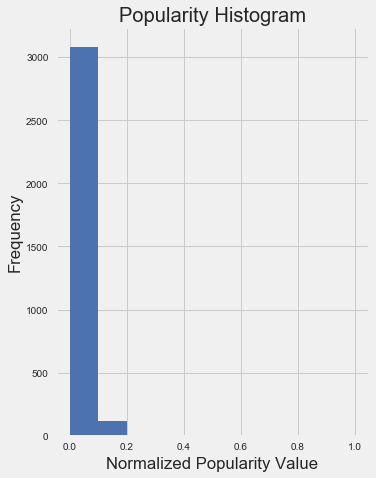

In [34]:
import matplotlib.pyplot as plt
plt.hist(b)
plt.title("Popularity Histogram")
plt.xlabel("Normalized Popularity Value")
plt.ylabel("Frequency")
fig5=plt.gcf()
fig5

#### Here, we incorporate the formula on success, which we will attribute 50% to the financial side, and 50% to popularity. The top values are:

In [35]:
success=0.5*a+0.5*b

In [36]:
sorted(success, reverse=True)[:10]

[0.51164916260974758,
 0.51116535677606179,
 0.41650371202499875,
 0.35974321188661224,
 0.31995110213190747,
 0.31505081501136506,
 0.30928851200978164,
 0.30348900802079215,
 0.27798026224673944,
 0.27602961313399971]

<br> The "success" values will be our target values that we are trying to predict.
### Below, we import data from the other dataset with credits, and merge our data together. The dimensions are:

In [37]:
credit_df = pd.read_csv("credits.csv",dtype=str)[['title', 'cast']]

all_df = pd.merge(dfclean3, credit_df, how='inner', left_on='original_title', right_on='title',
         left_index=False, right_index=False)
all_df.shape

(3106, 24)

#### Our target is to classify the data as "unsuccessful", "successful", and "very successful", as in the table below:

| Percentile    | Class              |
|---------------|--------------------|
| p < 10        | Unsuccessful       |
| 10 <= p <= 95 | Successful         |
| p > 95        | Very Successful    |

In [38]:
from scipy.stats import boxcox, percentileofscore
import matplotlib.pyplot as plt

# transform the success using box-cox transformation
success_transformed, maxlog = boxcox(success)

# Draw the line at said percentiles

success_result = []

for val in success_transformed:
    p = percentileofscore(success_transformed, val)
    if(p < 10):
        success_result.append("Unsucessful")
    elif(10 <= p <= 95 ):
        success_result.append("Successful")
    else:
        success_result.append("Very Successful")
success_result = pd.Series(success_result, dtype = "category")

In [39]:
cast = []

for row in all_df['cast']:
    try:
        dictionary = eval(row)[0]
        cast.append(dictionary['name'])
    except:
        # no cast
        cast.append(np.NaN)       
cast = pd.Series(cast, dtype = "category") 

In [40]:
production_companies = []

for row in dfclean2['production_companies']:
    dictionary = eval(row)
    try:
        production_companies.append(dictionary[0]['name'])
    except:
        # no production comp
        production_companies.append(np.NaN)        
production_companies = pd.Series(production_companies, dtype = "category")

In [41]:
genres = []

for row in dfclean2['genres']:
    dictionary = eval(row)
    try:
        genres.append(dictionary[0]['name'])
    except:
        # no genres
        genres.append(np.NaN)     
genres = pd.Series(genres, dtype = "category")

In [42]:
main_df = pd.concat([production_companies, cast, genres, success_result], axis=1)

main_df.columns = ["production companies", "cast", "genres", "sucess_result"]

main_df["production_code"] = main_df["production companies"].cat.codes
main_df["cast_code"] = main_df["cast"].cat.codes
main_df["genres_code"] = main_df["genres"].cat.codes

main_df.dropna(inplace = True)
main_df.head()

,production companies,cast,genres,sucess_result,production_code,cast_code,genres_code
0,Ingenious Film Partners,Sam Worthington,Action,Very Successful,327,1025,0
1,Walt Disney Pictures,Johnny Depp,Adventure,Very Successful,708,598,1
2,Columbia Pictures,Daniel Craig,Action,Very Successful,143,260,0
3,Legendary Pictures,Christian Bale,Action,Very Successful,377,213,0
4,Walt Disney Pictures,Taylor Kitsch,Action,Successful,708,1117,0


### The following declares X and y, and builds a random forest classifier from sklearn.

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier(n_estimators=700, max_depth=11, random_state=0)
X = main_df[["production_code", "cast_code", "genres_code"]]
y = main_df["sucess_result"]

### Below is a histogram with the histogram of our success data points, after cleaning them nicely.

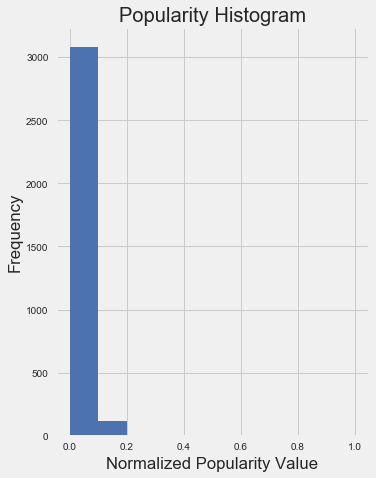

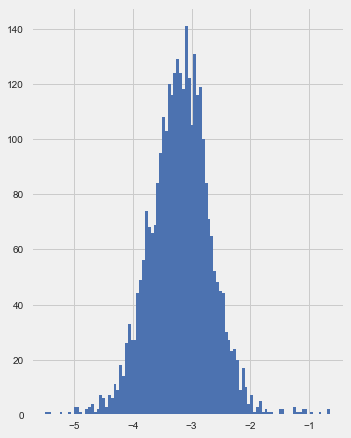

In [44]:
fig = plt.figure()
plt.hist(success_transformed,bins=100)
plt.show()

### Using Grid Search, we found the optimal depth and n_estimators values for our random forest:

In [45]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

param_grid = { 
    'n_estimators': [200, 700, 1000],
    'max_depth' : [9,10,11],
}

CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
CV_rfc.fit(X, y)
print (CV_rfc.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'max_depth': 11, 'n_estimators': 700}


### Below, we separate the training from testing set, and calculate our accuracy

In [46]:
from sklearn.cross_validation import train_test_split
# split the data with 80% in the training set 
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.8)
# fit the model on one set of data
model.fit(X1, y1)
# evaluate the model on the second set of data
y2_model = model.predict(X2)
finalscore=accuracy_score(y2, y2_model)
print(finalscore)

0.925


## We get 92.5% accuracy when cutting the line at 10th and 95th percentiles for success!
<br> For future work, we should include more parameters , as suggested on the comments Log notebook.
<br> Please have a look at the Log notebook for a full list of my attempts.
<br> spoiler: I started with a low %.